<a href="https://colab.research.google.com/github/anjali0503/Convolutional-Neural-Network/blob/main/Intel_Image_Classification_using_CNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# importing depandencies

import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
! kaggle datasets download puneet6060/intel-image-classification

 96% 331M/346M [00:03<00:00, 97.1MB/s]
100% 346M/346M [00:03<00:00, 109MB/s] 


In [ ]:
! unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [ ]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [ ]:
#Data Loading 

def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['/content/seg_train/seg_train', '/content/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/seg_train/seg_train


100%|██████████| 2404/2404 [00:01<00:00, 1701.81it/s]


Loading /content/seg_test/seg_test


100%|██████████| 553/553 [00:00<00:00, 1751.86it/s]


In [ ]:
#Dataset Eploration
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


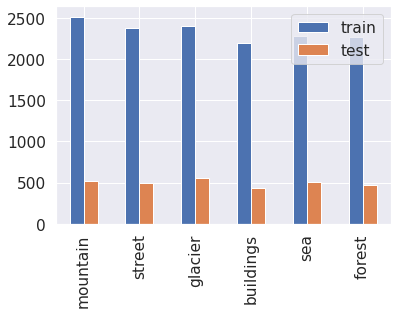

In [ ]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()


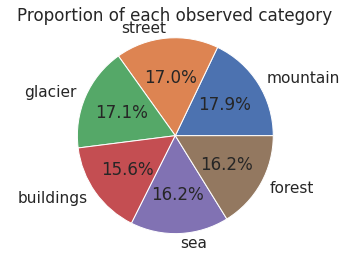

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
# Data Scaling 
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [ ]:

#Data Visualization
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])

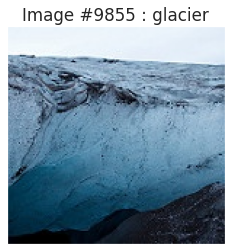

In [ ]:
display_random_image(class_names, train_images, train_labels)

In [ ]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

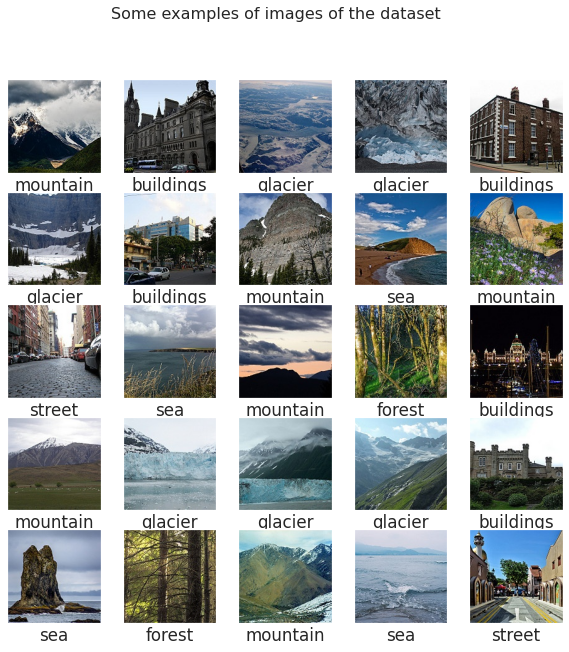

In [ ]:
display_examples(class_names, train_images, train_labels)

In [ ]:
#Model Creation

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
88/88 [==============================] - 248s 3s/step - loss: 1.2983 - accuracy: 0.5191 - val_loss: 0.8869 - val_accuracy: 0.6616
Epoch 2/10
88/88 [==============================] - 252s 3s/step - loss: 0.7933 - accuracy: 0.7065 - val_loss: 0.6982 - val_accuracy: 0.7488
Epoch 3/10
88/88 [==============================] - 251s 3s/step - loss: 0.6303 - accuracy: 0.7723 - val_loss: 0.6616 - val_accuracy: 0.7638
Epoch 4/10
88/88 [==============================] - 252s 3s/step - loss: 0.5173 - accuracy: 0.8201 - val_loss: 0.6167 - val_accuracy: 0.7887
Epoch 5/10
88/88 [==============================] - 251s 3s/step - loss: 0.3916 - accuracy: 0.8676 - val_loss: 0.6783 - val_accuracy: 0.7709
Epoch 6/10
88/88 [==============================] - 252s 3s/step - loss: 0.2966 - accuracy: 0.9028 - val_loss: 0.6880 - val_accuracy: 0.7713
Epoch 7/10
88/88 [==============================] - 251s 3s/step - loss: 0.2251 - accuracy: 0.9308 - val_loss: 0.6745 - val_accuracy: 0.7848
Epoch 8/10
88

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

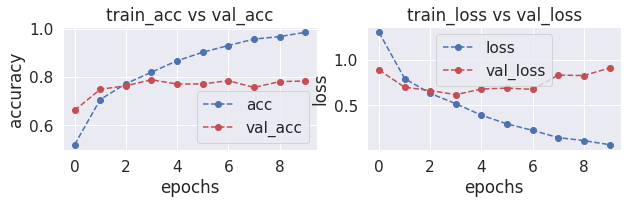

In [ ]:
plot_accuracy_loss(history)

In [ ]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 17s 184ms/step - loss: 0.9394 - accuracy: 0.7707


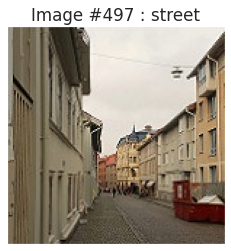

In [ ]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [ ]:
#Error Analysis
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

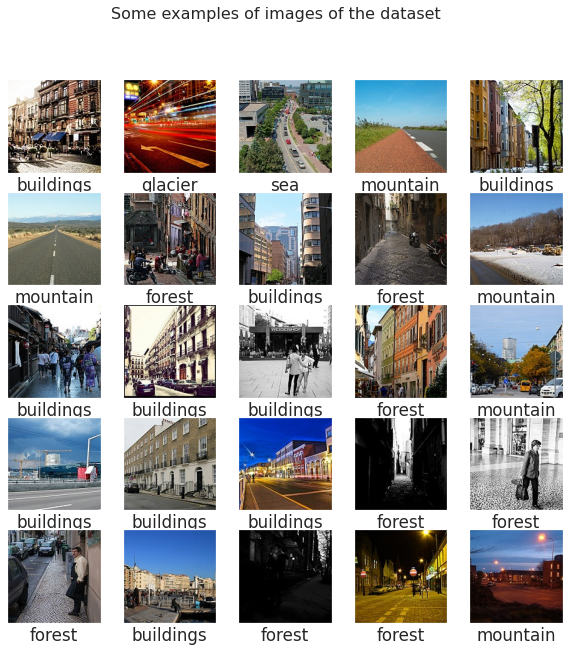

In [ ]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

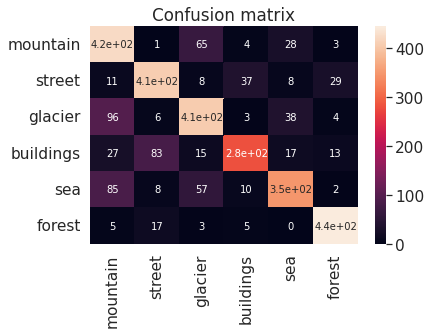

In [ ]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
#Feature extraction with VGG ImageNet
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [ ]:
#Visualize the features through PCA

n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [ ]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]

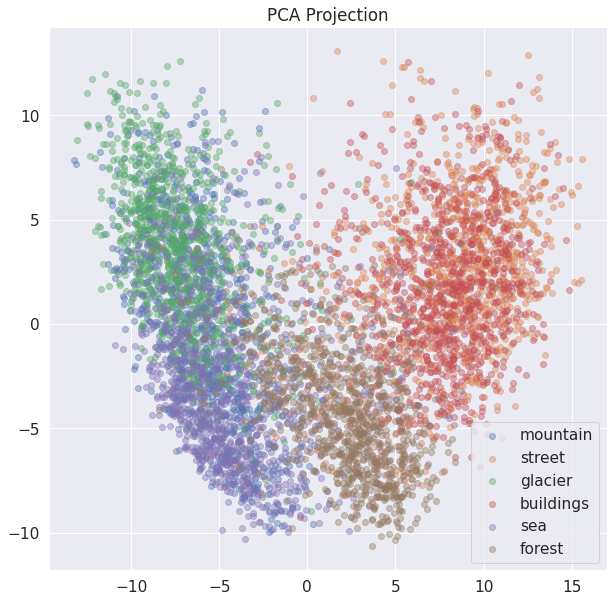

In [ ]:
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

In [ ]:
#Training on top of VGG¶
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 1s 13ms/step - loss: 0.5362 - accuracy: 0.8015 - val_loss: 0.3665 - val_accuracy: 0.8621
Epoch 2/15
88/88 [==============================] - 1s 11ms/step - loss: 0.3071 - accuracy: 0.8888 - val_loss: 0.3432 - val_accuracy: 0.8782
Epoch 3/15
88/88 [==============================] - 1s 11ms/step - loss: 0.2421 - accuracy: 0.9151 - val_loss: 0.3475 - val_accuracy: 0.8760
Epoch 4/15
88/88 [==============================] - 1s 12ms/step - loss: 0.2037 - accuracy: 0.9289 - val_loss: 0.3327 - val_accuracy: 0.8814
Epoch 5/15
88/88 [==============================] - 1s 11ms/step - loss: 0.1709 - accuracy: 0.9429 - val_loss: 0.3400 - val_accuracy: 0.8778
Epoch 6/15
88/88 [==============================] - 1s 12ms/step - loss: 0.1469 - accuracy: 0.9513 - val_loss: 0.3431 - val_accuracy: 0.8792
Epoch 7/15
88/88 [==============================] - 1s 12ms/step - loss: 0.1165 - accuracy: 0.9642 - val_loss: 0.3567 - val_accuracy: 0.8778
Epoch 8/15
88

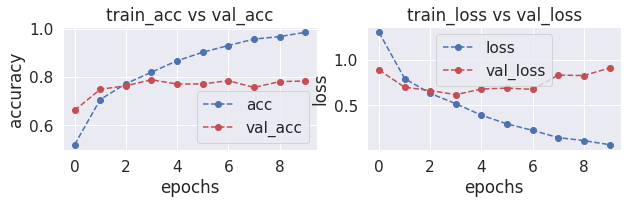

In [ ]:
plot_accuracy_loss(history)

In [ ]:
test_loss = model2.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 2ms/step - loss: 0.4240 - accuracy: 0.8763


In [ ]:
#Ensemble Neural Networks

np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

In [ ]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [ ]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Epoch 1/10
79/79 [==============================] - 1s 15ms/step - loss: 0.5206 - accuracy: 0.8047 - val_loss: 0.3400 - val_accuracy: 0.8896
Epoch 2/10
79/79 [==============================] - 1s 14ms/step - loss: 0.2542 - accuracy: 0.9109 - val_loss: 0.2726 - val_accuracy: 0.9083
Epoch 3/10
79/79 [==============================] - 1s 14ms/step - loss: 0.1816 - accuracy: 0.9385 - val_loss: 0.2564 - val_accuracy: 0.9190
Epoch 4/10
79/79 [==============================] - 1s 14ms/step - loss: 0.1338 - accuracy: 0.9579 - val_loss: 0.2351 - val_accuracy: 0.9225
Epoch 5/10
79/79 [==============================] - 1s 14ms/step - loss: 0.1041 - accuracy: 0.9698 - val_loss: 0.2266 - val_accuracy: 0.9332
Epoch 6/10
79/79 [==============================] - 1s 14ms/step - loss: 0.0740 - accuracy: 0.9811 - val_loss: 0.2214 - val_accuracy: 0.9332
Epoch 7/10
79/79 [==============================] - 1s 14ms/step - loss: 0.0560 - accuracy: 0.9882 - val_loss: 0.2085 - val_accuracy: 0.9359
Epoch 8/10
79

In [ ]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.8886666666666667
